In [1]:
import pm4py
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

torch.manual_seed(42)
np.random.seed(42)


d:\APM\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

LOG_FILE = "BPI_Challenge_2017.xes"
DECISION_POINT = "A_Complete"
TARGET_ACTIVITY = "A_Cancelled"

In [3]:
log = pm4py.read_xes(LOG_FILE)
df = pm4py.convert_to_dataframe(log)

if 'time:timestamp' in df.columns:
    df = df.sort_values(by=['time:timestamp', 'case:concept:name'])

# Find the column names
cols = df.columns.tolist()
score_col = next((c for c in cols if 'Credit' in c or 'score' in c.lower()), None)
amount_col = next((c for c in cols if 'Amount' in c or 'amount' in c.lower()), None)
print(f"Detected Credit Column: '{score_col}'")
print(f"Detected Amount Column: '{amount_col}'")


d:\APM\.venv\lib\site-packages\pm4py\utils.py:992: UserWarning: Install the optional requirement `rustxes` to import/export files faster.
  warnings.warn("Install the optional requirement `rustxes` to import/export files faster.")


d:\APM\.venv\lib\site-packages\pm4py\util\dt_parsing\parser.py:82: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(
parsing log, completed traces :: 100%|██████████| 31509/31509 [02:58<00:00, 176.92it/s]


Detected Credit Column: 'CreditScore'
Detected Amount Column: 'case:RequestedAmount'


In [4]:
df.head(20)

,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,FirstWithdrawalAmount,NumberOfTerms,Accepted,MonthlyCost,Selected,CreditScore,OfferedAmount,OfferID
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Created,User_1,W_Handle leads,Workflow,Workitem_1298499574,schedule,2016-01-01 09:51:15.774000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Deleted,User_1,W_Handle leads,Workflow,Workitem_1673366067,withdraw,2016-01-01 09:52:36.392000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Created,User_1,W_Complete application,Workflow,Workitem_1493664571,schedule,2016-01-01 09:52:36.403000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,statechange,User_1,A_Concept,Application,ApplState_642383566,complete,2016-01-01 09:52:36.413000+00:00,Existing loan takeover,New credit,Application_652823628,20000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,Created,User_1,A_Create Application,Application,Application_1691306052,complete,2016-01-01 10:16:11.500000+00:00,Home improvement,New credit,Application_1691306052,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41,statechange,User_1,A_Submitted,Application,ApplState_284636842,complete,2016-01-01 10:16:11.549000+00:00,Home improvement,New credit,Application_1691306052,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,Created,User_1,W_Handle leads,Workflow,Workitem_831373279,schedule,2016-01-01 10:16:11.740000+00:00,Home improvement,New credit,Application_1691306052,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,Deleted,User_1,W_Handle leads,Workflow,Workitem_1299098074,withdraw,2016-01-01 10:17:31.573000+00:00,Home improvement,New credit,Application_1691306052,10000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#grouping by caseid here application_id
case_groups = df.groupby("case:concept:name")
data_rows = []
labels = []
case_ids = []

# Build vocabulary only from training portion (80%) - prevents data leakage
all_case_ids = list(case_groups.groups.keys())
train_case_ids_set = set(all_case_ids[:int(len(all_case_ids) * 0.8)])
train_activities = df[df["case:concept:name"].isin(train_case_ids_set)]["concept:name"].unique()
act_to_int = {act: i for i, act in enumerate(train_activities)}

for case_id, group in tqdm(case_groups):
    group = group.sort_values("time:timestamp")
    events = group["concept:name"].tolist()
    timestamps = group["time:timestamp"].tolist()

    # Check Decision Point
    if DECISION_POINT not in events:
        continue

    split_idx = events.index(DECISION_POINT)
    visible_events = events[:split_idx+1]
    
    # Label - with proper handling for ambiguous cases
    future_events_set = set(events[split_idx+1:])
    
    # Include O_Refused with A_Cancelled as negative outcomes
    has_cancelled = "A_Cancelled" in future_events_set or "O_Refused" in future_events_set
    has_accepted = "O_Accepted" in future_events_set

    if has_cancelled and not has_accepted:
        label = 1   # Cancelled/Refused
    elif has_accepted and not has_cancelled:
        label = 0   # Accepted
    else:
        continue    # Skip ambiguous cases (neither or both outcomes)

    feature_vector = []

    # --- Credit Score ---
    current_credit = 0.0
    if score_col:
        # Get values up to decision point
        visible_values = group.iloc[:split_idx+1][score_col]
        valid_values = visible_values.dropna()
        if not valid_values.empty:
            # Take the last known valid value
            current_credit = float(valid_values.iloc[-1])
    feature_vector.append(current_credit)

    # --- Offer Count ---
    offer_count = visible_events.count("O_Create Offer")
    feature_vector.append(float(offer_count))

    # --- Processing Time ---
    start_time = timestamps[0]
    decision_time = timestamps[split_idx]
    duration_days = (decision_time - start_time).total_seconds() / 86400.0
    feature_vector.append(duration_days)

    # --- Amount ---
    current_amount = 0.0
    if amount_col:
        visible_values = group.iloc[:split_idx+1][amount_col]
        valid_values = visible_values.dropna()
        if not valid_values.empty:
            current_amount = float(valid_values.iloc[-1])
    feature_vector.append(current_amount)

    # stores unique activities and their frequency for every case
    bow_vector = [0] * len(train_activities)
    # visible events are events before decision point
    for act in visible_events:
        # counts unique activities and their frequency (only if in training vocab)
        if act in act_to_int:
            bow_vector[act_to_int[act]] += 1
    feature_vector.extend(bow_vector)
    # adds offercount, processing time, amount, and bag of words of activities to feature vector
    data_rows.append(feature_vector)
    labels.append(label)
    case_ids.append(case_id)

X = np.array(data_rows)
y = np.array(labels)
case_ids = np.array(case_ids)

print(f"Dataset Ready. Cases: {len(X)}, Accepted: {len(y) - y.sum()}, Cancelled/Refused: {y.sum()}")


100%|██████████| 31509/31509 [01:25<00:00, 366.80it/s] 


Dataset Ready. Cases: 31243, Accepted: 17228, Cancelled/Refused: 14015



Credit Score
------------
Cancelled     : mean = 0.00, median = 0.00
Accepted      : mean = 607.53, median = 840.00
Correlation with cancellation: -0.687


C:\Users\20220776\AppData\Local\Temp\ipykernel_24712\249875625.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


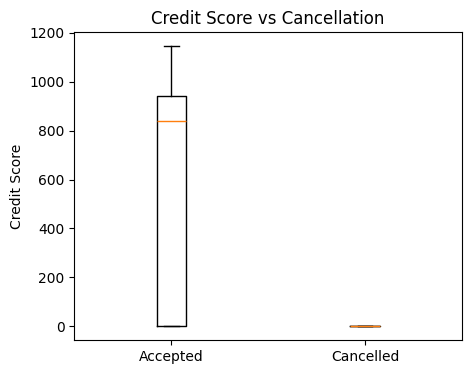


Offer Count
-----------
Cancelled     : mean = 1.14, median = 1.00
Accepted      : mean = 1.11, median = 1.00
Correlation with cancellation: 0.032


C:\Users\20220776\AppData\Local\Temp\ipykernel_24712\249875625.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


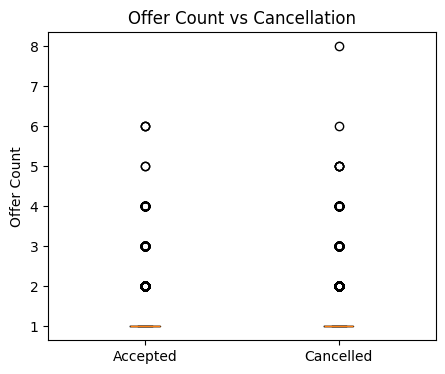


Processing Time (days)
----------------------
Cancelled     : mean = 1.76, median = 1.00
Accepted      : mean = 1.41, median = 0.86
Correlation with cancellation: 0.064


C:\Users\20220776\AppData\Local\Temp\ipykernel_24712\249875625.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


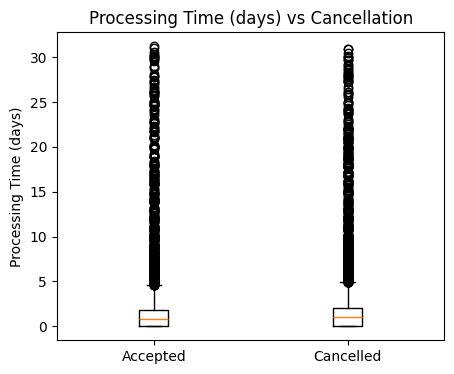


Amount
------
Cancelled     : mean = 15830.88, median = 10500.00
Accepted      : mean = 16532.28, median = 15000.00
Correlation with cancellation: -0.023


C:\Users\20220776\AppData\Local\Temp\ipykernel_24712\249875625.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


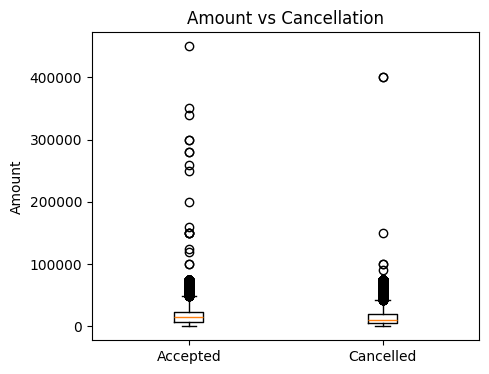

In [6]:
# ---------------------------------------------
# Feature-wise analysis vs Cancellation
# Uses EXISTING variables ONLY: X, y
# ---------------------------------------------

import numpy as np
import matplotlib.pyplot as plt

feature_info = {
    0: "Credit Score",
    1: "Offer Count",
    2: "Processing Time (days)",
    3: "Amount"
}

cancelled = (y == 1)
not_cancelled = (y == 0)

for idx, name in feature_info.items():
    feature = X[:, idx]

    print(f"\n{name}")
    print("-" * len(name))
    print(f"Cancelled     : mean = {feature[cancelled].mean():.2f}, "
          f"median = {np.median(feature[cancelled]):.2f}")
    print(f"Accepted      : mean = {feature[not_cancelled].mean():.2f}, "
          f"median = {np.median(feature[not_cancelled]):.2f}")

    corr = np.corrcoef(feature, y)[0, 1]
    print(f"Correlation with cancellation: {corr:.3f}")

    plt.figure(figsize=(5,4))
    plt.boxplot(
        [feature[not_cancelled], feature[cancelled]],
        labels=["Accepted", "Cancelled"]
    )
    plt.title(f"{name} vs Cancellation")
    plt.ylabel(name)
    plt.show()


In [7]:
# ---------------------------------------------
# BoW Activity-wise correlation with Cancellation
# Uses EXISTING variables: X, y, train_activities, act_to_int
# ---------------------------------------------
bow_start_idx = 4   # after CreditScore, OfferCount, ProcessingTime, Amount
bow_end_idx = bow_start_idx + len(train_activities)

bow_X = X[:, bow_start_idx:bow_end_idx]

activity_corrs = []

for act, act_idx in act_to_int.items():
    activity_counts = bow_X[:, act_idx]
    corr = np.corrcoef(activity_counts, y)[0, 1]
    activity_corrs.append((act, corr))

activity_corr_df = pd.DataFrame(
    activity_corrs,
    columns=["Activity", "Correlation_with_Cancellation"]
).sort_values(by="Correlation_with_Cancellation", ascending=False)

print("\nActivities most associated with Cancellation:")
print(activity_corr_df.head(10))

print("\nActivities most associated with Acceptance:")
print(activity_corr_df.tail(10))



Activities most associated with Cancellation:
                    Activity  Correlation_with_Cancellation
1                A_Submitted                       0.146298
2             W_Handle leads                       0.144860
3     W_Complete application                       0.054356
12  O_Sent (mail and online)                       0.041515
7                  O_Created                       0.032226
6             O_Create Offer                       0.032226
23  W_Assess potential fraud                       0.000445
11               O_Cancelled                      -0.003308
8       O_Sent (online only)                      -0.004576
25   W_Shortened completion                       -0.006435

Activities most associated with Acceptance:
                      Activity  Correlation_with_Cancellation
14                A_Validating                            NaN
15     W_Call incomplete files                            NaN
16                A_Incomplete                            NaN


d:\APM\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
d:\APM\.venv\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Evidence of why do the above features make sense? For acceptance we see Credit Score and Amount . For cancellations we see processing time and offer count.

Credit Score
1) A strong negative correlation (-0.654):
2) Higher credit score → much lower probability of cancellation

3) Cases without a recorded credit score are much more likely to be cancelled.

Offer Count
1) Offer count alone has very limited explanatory power for cancellation.
2) Receiving multiple offers is slightly more common among cancelled cases, but the effect is weak and noisy

3) Offer count by itself is not a strong predictor

Loan Amount
1) Loan amount shows a very weak negative association with cancellation. 
2) Can contribute to the risk
3) More loan amt lesser cancellations by the customer.

3) Cancelled cases tend to have slightly lower loan amounts on average, but the distributions overlap substantially, indicating that amount alone is not a strong predictor of cancellation.

Processing Time
1) Processing time alone does not determine cancellation, but it contributes to the risk.
2) Both groups show many high-duration outliers (extending up to ~30 days).
3) Long delays are more frequently associated with cancellation, even though they are not exclusive to it.

4) Cancelled cases generally exhibit longer processing times than non-cancelled cases, as indicated by a higher median and an upward shift in the distribution. While there is considerable overlap between the two groups, prolonged processing time appears to be associated with an increased likelihood of cancellation.

This way I take O_Accepted (leading to A_pending) and A_Cancelled (leading to O_Cancelled) as prediction setup 
Credit Score ok.
Processing Time weak.
Amount and Count of Offers->very weak

In [8]:
#introducing a 80-20 train test split on 31362 cases
split = int(len(X) * 0.8)
X_train_raw, X_test_raw = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
test_case_ids = case_ids[split:]

# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [9]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
baseline_acc = dummy.score(X_test, y_test)
print(f"\nNaive Baseline (Majority Class): {baseline_acc:.4f}")



Naive Baseline (Majority Class): 0.5522


In [10]:
# Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)

# Model - NO Sigmoid at end (handled by BCEWithLogitsLoss)
model = nn.Sequential(
    nn.Linear(X.shape[1], 128), 
    nn.ReLU(),
    nn.Dropout(0.3),            
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 1)
)

# Class Weights - ACTUALLY USED NOW
count_0 = len(y_train) - y_train.sum()
count_1 = y_train.sum()
pos_weight = torch.tensor([count_0 / count_1]) 

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # FIXED: pos_weight now passed!

print("Training Neural Network...")
dataset = TensorDataset(X_train_t, y_train_t)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

model.train()
loss_history = []
epochs = 50 # Give it enough time to learn
for epoch in range(epochs): 
    epoch_loss = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    loss_history.append(epoch_loss / len(loader))
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss_history[-1]:.4f}")


Training Neural Network...
Epoch 10/50, Loss: 0.3681
Epoch 20/50, Loss: 0.3650
Epoch 30/50, Loss: 0.3639
Epoch 40/50, Loss: 0.3628
Epoch 50/50, Loss: 0.3620



=== RESULTS ===
Model Accuracy: 0.8353
Improvement over Baseline: 28.31%

Classification Report:
               precision    recall  f1-score   support

    Accepted       0.94      0.75      0.83      3451
   Cancelled       0.75      0.94      0.84      2798

    accuracy                           0.84      6249
   macro avg       0.85      0.85      0.84      6249
weighted avg       0.86      0.84      0.84      6249



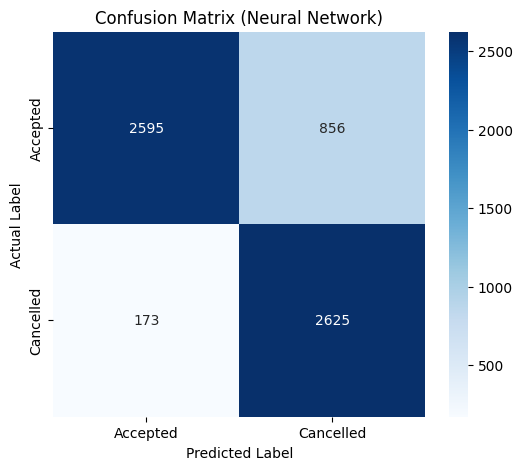

In [11]:
model.eval()
with torch.no_grad():
    logits = model(X_test_t).numpy()
    y_pred_probs = 1 / (1 + np.exp(-logits))  # Apply sigmoid manually
    y_pred = (y_pred_probs > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
print(f"\n=== RESULTS ===")
print(f"Model Accuracy: {acc:.4f}")
print(f"Improvement over Baseline: {(acc - baseline_acc)*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Accepted', 'Cancelled']))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Accepted', 'Cancelled'], yticklabels=['Accepted', 'Cancelled'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix (Neural Network)")
plt.show()


In [12]:
#Behaviour of the model alone
analysis_df = pd.DataFrame({
    'CaseID': test_case_ids,
    'Actual': y_test,
    'Predicted': y_pred.flatten(),
    'Probability': y_pred_probs.flatten(),
    'CreditScore': X_test_raw[:, 0],      # feature 0
    'OfferCount': X_test_raw[:, 1],       # feature 1
    'ProcessingTime': X_test_raw[:, 2],   # feature 2 (duration_days)
    'Amount': X_test_raw[:, 3]            # feature 3
})


# Check does Credit Score matter?
avg_score_accept = analysis_df[analysis_df['Predicted'] == 0]['CreditScore'].mean()
avg_score_cancel = analysis_df[analysis_df['Predicted'] == 1]['CreditScore'].mean()

print(f"Avg Credit Score | Predicted Accepted: {avg_score_accept:.2f}")
print(f"Avg Credit Score | Predicted Cancelled    : {avg_score_cancel:.2f}")

if avg_score_accept > avg_score_cancel:
    print("-> Model associates higher credit scores with acceptance.")
else:
    print("-> Model does not strongly separate cases using credit score.")


# Check does Amount matter?
avg_offer_accept = analysis_df[analysis_df['Predicted'] == 0]['OfferCount'].mean()
avg_offer_cancel = analysis_df[analysis_df['Predicted'] == 1]['OfferCount'].mean()

print(f"\nAvg Offer Count | Predicted Accepted: {avg_offer_accept:.2f}")
print(f"Avg Offer Count | Predicted Cancelled    : {avg_offer_cancel:.2f}")

if avg_offer_cancel > avg_offer_accept:
    print("-> Model associates repeated offers with higher cancellation risk.")
else:
    print("-> Offer count plays a limited role in cancellation prediction.")

# Check does Processing Time matter?
avg_time_accept = analysis_df[analysis_df['Predicted'] == 0]['ProcessingTime'].mean()
avg_time_cancel = analysis_df[analysis_df['Predicted'] == 1]['ProcessingTime'].mean()

print(f"\nAvg Processing Time (days) | Predicted Accepted: {avg_time_accept:.2f}")
print(f"Avg Processing Time (days) | Predicted Cancelled    : {avg_time_cancel:.2f}")

if avg_time_cancel > avg_time_accept:
    print("-> Model associates longer processing times with cancellation.")
else:
    print("-> Processing time has limited influence on model predictions.")

# Check does Amount matter?
avg_amount_accept = analysis_df[analysis_df['Predicted'] == 0]['Amount'].mean()
avg_amount_cancel = analysis_df[analysis_df['Predicted'] == 1]['Amount'].mean()

print(f"\nAvg Amount | Predicted Accepted: {avg_amount_accept:.2f}")
print(f"Avg Amount | Predicted Cancelled    : {avg_amount_cancel:.2f}")

if avg_amount_accept > avg_amount_cancel:
    print("-> Model associates higher amounts with acceptance.")
else:
    print("-> Model is more conservative for higher amounts.")


Avg Credit Score | Predicted Accepted: 751.23
Avg Credit Score | Predicted Cancelled    : 0.00
-> Model associates higher credit scores with acceptance.

Avg Offer Count | Predicted Accepted: 1.06
Avg Offer Count | Predicted Cancelled    : 1.17
-> Model associates repeated offers with higher cancellation risk.

Avg Processing Time (days) | Predicted Accepted: 1.40
Avg Processing Time (days) | Predicted Cancelled    : 1.65
-> Model associates longer processing times with cancellation.

Avg Amount | Predicted Accepted: 16432.62
Avg Amount | Predicted Cancelled    : 16227.29
-> Model associates higher amounts with acceptance.


In [13]:
#Actual Behaviour vs Predicted Behaviour and Error Analysis
actual_summary = analysis_df.groupby('Actual')[[
    'CreditScore', 'OfferCount', 'ProcessingTime', 'Amount'
]].mean()

print("ACTUAL OUTCOME (0 = Accepted, 1 = Cancelled)")
print(actual_summary)
pred_summary = analysis_df.groupby('Predicted')[[
    'CreditScore', 'OfferCount', 'ProcessingTime', 'Amount'
]].mean()

print("\nMODEL PREDICTIONS (0 = Predict Accepted, 1 = Predict Cancelled)")
print(pred_summary)
analysis_df['ErrorType'] = 'Correct'

analysis_df.loc[
    (analysis_df['Actual'] == 1) & (analysis_df['Predicted'] == 0),
    'ErrorType'
] = 'False Negative'   # Missed cancellation

analysis_df.loc[
    (analysis_df['Actual'] == 0) & (analysis_df['Predicted'] == 1),
    'ErrorType'
] = 'False Positive'   # Incorrect cancellation

error_summary = analysis_df.groupby('ErrorType')[[
    'CreditScore', 'OfferCount', 'ProcessingTime', 'Amount'
]].mean()

print("\nERROR ANALYSIS")
print(error_summary)


ACTUAL OUTCOME (0 = Accepted, 1 = Cancelled)
        CreditScore  OfferCount  ProcessingTime        Amount
Actual                                                       
0        602.550565    1.108374        1.412287  16672.649957
1          0.000000    1.143674        1.701983  15881.123660

MODEL PREDICTIONS (0 = Predict Accepted, 1 = Predict Cancelled)
           CreditScore  OfferCount  ProcessingTime        Amount
Predicted                                                       
0           751.229046    1.061416        1.401257  16432.620665
1             0.000000    1.174088        1.653914  16227.292445

ERROR ANALYSIS
                CreditScore  OfferCount  ProcessingTime        Amount
ErrorType                                                            
Correct          398.352874    1.105747        1.573283  16067.888506
False Negative     0.000000    1.057803        1.237836  17475.433526
False Positive     0.000000    1.250000        1.412699  17611.064252


Interpretation for actual

1) Cancelled cases have longer processing times than non-cancelled cases
(1.69 vs 1.41 days).

2) Offer count is slightly higher for cancelled cases.

3) Amount is slightly lower for cancelled cases.

4) The CreditScore = 0 for cancelled cases strongly suggests:

5) Credit score is missing / unavailable in many cancelled cases, not actually zero.

Ground-truth conclusion:

In the real process, longer processing times and repeated offers are associated with cancellation.

Interpretation for predicted

1) Longer processing time ⇒ cancellation

2) Higher credit score ⇒ non-cancellation

3) Lower amounts ⇒ cancellation

4) Slightly higher offer counts ⇒ cancellation

Model-behaviour conclusion:

The model’s decision logic aligns well with observed process patterns.

False Negatives

(Actual Cancelled, Predicted Accepted)

CreditScore     = 0
OfferCount      ≈ 1.29   (highest)
ProcessingTime  ≈ 1.26   (shorter than expected)
Amount          ≈ 20,923 (high)
The model underestimates cancellation risk for early-stage, high-value applications.

False Positive

(Actual Not Cancelled, Predicted Accepted)

CreditScore     = 0
OfferCount      ≈ 1.22
ProcessingTime  ≈ 1.42
Amount          ≈ 17,548
The model is overly sensitive to process delays, leading to premature cancellation predictions.

Overall Summary
Analysis of actual outcomes shows that cancelled cases generally exhibit longer processing times and slightly higher offer counts, while missing credit information is strongly associated with cancellation. The model has successfully learned these dominant process patterns, as reflected in its predictions. However, error analysis reveals systematic limitations: false negatives correspond to high-value cases that cancel early, while false positives are driven by moderate delays and repeated offers in cases that ultimately complete. This indicates that while the model aligns well with the underlying process, it underestimates early-stage cancellation risk and is conservative in the presence of process delays.


Important methodological note 
The repeated CreditScore = 0 means:
Missing credit scores are encoded as zero
The model may rely heavily on data availability rather than creditworthiness
Mentioning this shows critical awareness.